# **Import Dataset**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_columns', None)

data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


# **Data Preprocessing**

In [2]:
print(f'Duplicate Items in Dataset:{data.duplicated().sum()}')

Duplicate Items in Dataset:5268


# **Remove Duplicate items from dataset**

In [3]:
data = data[~data.duplicated()]

# **Check for missing values**

In [4]:
print(f'Count of Missing values:{data.isnull().sum()}')

Count of Missing values:InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


# **Create new Invoice List**

In [5]:
#Creates a list of unique invoice No. with Null Customer ID

invoice_list = data[data.CustomerID.isnull()]['InvoiceNo'].tolist()
print(invoice_list[:10])

[536414, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544]


In [6]:
len(data[data.InvoiceNo.isin(invoice_list)])

135037

# **Create Train Data**

# Removing Inconsistent Records

In [7]:

print("The number of records with Quantity Negative and Prices 0 or Vice versa : ",data[(data.Quantity<=0) & (data.UnitPrice<=0)].shape[0])

#Checking if Negative quantities are cancelled items 
print("Cancelled Items have Invoice Starting with : ",data.loc[(data.Quantity<0) & ~(data.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

#Checking for Records with Negative Unit Price
print("The number of transactions with Negative Unit Price : ",data[(data.UnitPrice<0)].shape[0])

#Checking for Records with Unit Price 0
print("The number of transactions with Unit Price 0 : ",data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())].shape[0])


The number of records with Quantity Negative and Prices 0 or Vice versa :  1336
Cancelled Items have Invoice Starting with :  ['C']
The number of transactions with Negative Unit Price :  2
The number of transactions with Unit Price 0 :  40


In [8]:
#Removing records with Null Customer ID
data = data[data.CustomerID.notnull()]

#Removing Transactions with Unit Price 0
#data = data[data.UnitPrice>0]


In [9]:


rfm_train = data.copy()

In [10]:
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [11]:
print(f'Count of Missing values:{rfm_train.isnull().sum()}')

Count of Missing values:InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# **Cancelled Items**

In [12]:
## REMOVE transactions with Cancelled Items.

placed = rfm_train[~rfm_train.InvoiceNo.str.contains('C',na=False)]

In [13]:
placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice

<ipython-input-13-ee3f9bd42329>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice


# ***Exploratory Data Analysis***

In [14]:
# To Find The Time Period of Transactions

print(f'Oldest date is:{placed.InvoiceDate.min()}\n')
print(f'Latest date is:{placed.InvoiceDate.max()}\n')

Oldest date is:2010-12-01 08:26:00

Latest date is:2011-12-09 12:50:00



# **Order Density in Different Countries**

In [15]:
placed.Country.value_counts(normalize=True).head(12).mul(100).round(1).astype(str)+'%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Norway             0.3%
Italy              0.2%
Name: Country, dtype: object

<ipython-input-16-d377721275f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')


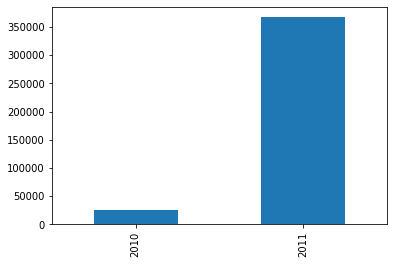

In [16]:
placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')
placed.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar')


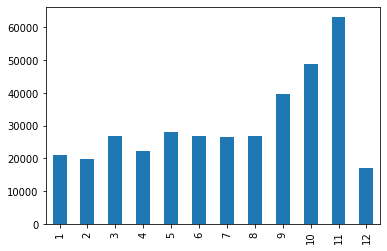

In [17]:
placed[placed.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')

# **Monthly Gross**

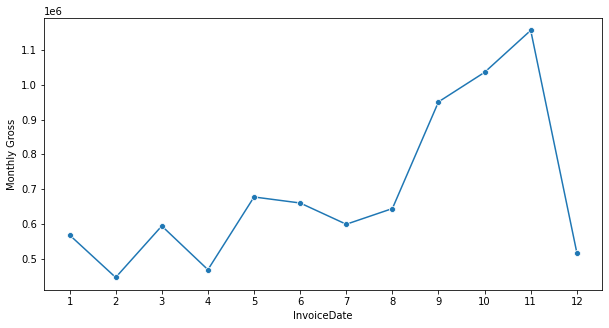

In [18]:
monthly_gross = placed[placed.InvoiceDate.dt.year==2011].groupby(placed.InvoiceDate.dt.month).TotalCost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index,marker='o')
plt.xticks(range(1,13))
plt.ylabel('Monthly Gross')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


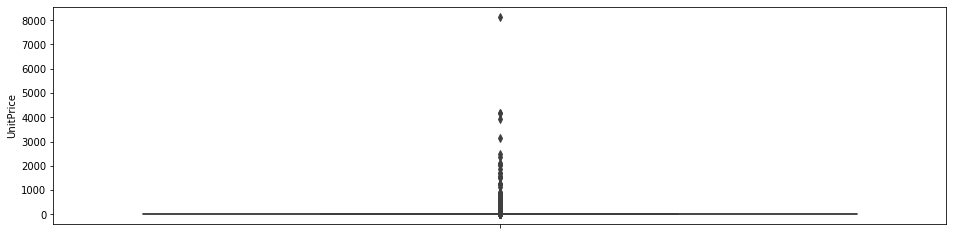

In [19]:
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice',data = placed,orient='h')

Unit Price is more concentrated in lower values of prices.

# **Top Selling Products**

In [20]:
placed.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


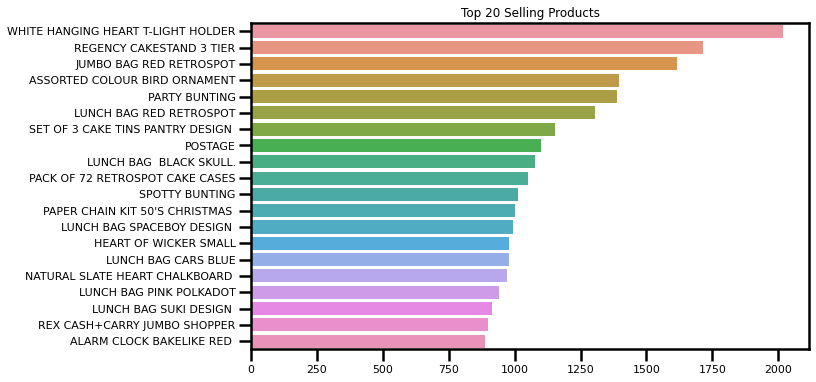

In [21]:
top_products = placed['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("poster",font_scale=0.5)
sns.barplot(y=top_products.index,x=top_products.values)
plt.title('Top 20 Selling Products')
plt.show()